In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
import json
seed = 42

plt.style.use('ggplot')
%config InlineBackend.figure_format='retina'

In [151]:
X, y = make_classification(
    n_samples=10000, n_features=20, n_classes=2, weights=[0.99, 0.01], random_state=seed
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed)

data = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}

In [152]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.001,
    'n_iterations': 100,
    'verbose': -1
}
num_boost_round = 100

In [153]:
neg_ws = [1, 10, 100, 1000, 10000]
neg_preds = {}
eval_negs = {}
for w in neg_ws:

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    weight = np.ones(len(y_train))
    weight[np.argwhere(y_train==0)] = w
    train_data.set_weight(weight)
    
    weight = np.ones(len(y_test))
    weight[np.argwhere(y_test==0)] = w
    test_data.set_weight(weight)

    evals = {}
    model = lgb.train(
        params, 
        train_data,
        valid_sets=[test_data],
        num_boost_round=num_boost_round,
        callbacks=[lgb.record_evaluation(evals)],
    )
    eval_negs[w] = evals
    neg_preds[w] = model.predict(X_test)

In [154]:
pos_ws = [1, 10, 100, 1000, 10000]
pos_preds = {}
eval_pos = {}
for w in neg_ws:

    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    weight = np.ones(len(y_train))
    weight[np.argwhere(y_train==1)] = w
    train_data.set_weight(weight)
    
    weight = np.ones(len(y_test))
    weight[np.argwhere(y_test==1)] = w
    test_data.set_weight(weight)

    evals = {}
    model = lgb.train(
        params, 
        train_data,
        valid_sets=[test_data],
        num_boost_round=num_boost_round,
        callbacks=[lgb.record_evaluation(evals)],
    )
    eval_pos[w] = evals
    pos_preds[w] = model.predict(X_test)

In [155]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.001,
    'n_iterations': 500,
    'verbose': -1,
    'balanced': True,
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
evals_balanced = {}
model = lgb.train(
    params, 
    train_data,
    valid_sets=[test_data], 
    num_boost_round=num_boost_round,
    callbacks=[lgb.record_evaluation(evals_balanced)],
)

In [159]:
for w, y_pred in pos_preds.items():
    print(w, roc_auc_score(y_test, y_pred))
for w, y_pred in neg_preds.items():
    print(w, roc_auc_score(y_test, y_pred))    

1 0.8696321409087366
10 0.8457836489751384
100 0.8355252903125243
1000 0.9099738913568701
10000 0.851141766035383
1 0.8696321409087366
10 0.9044988699244019
100 0.9026673680928999
1000 0.8972605408775622
10000 0.9065349544072949


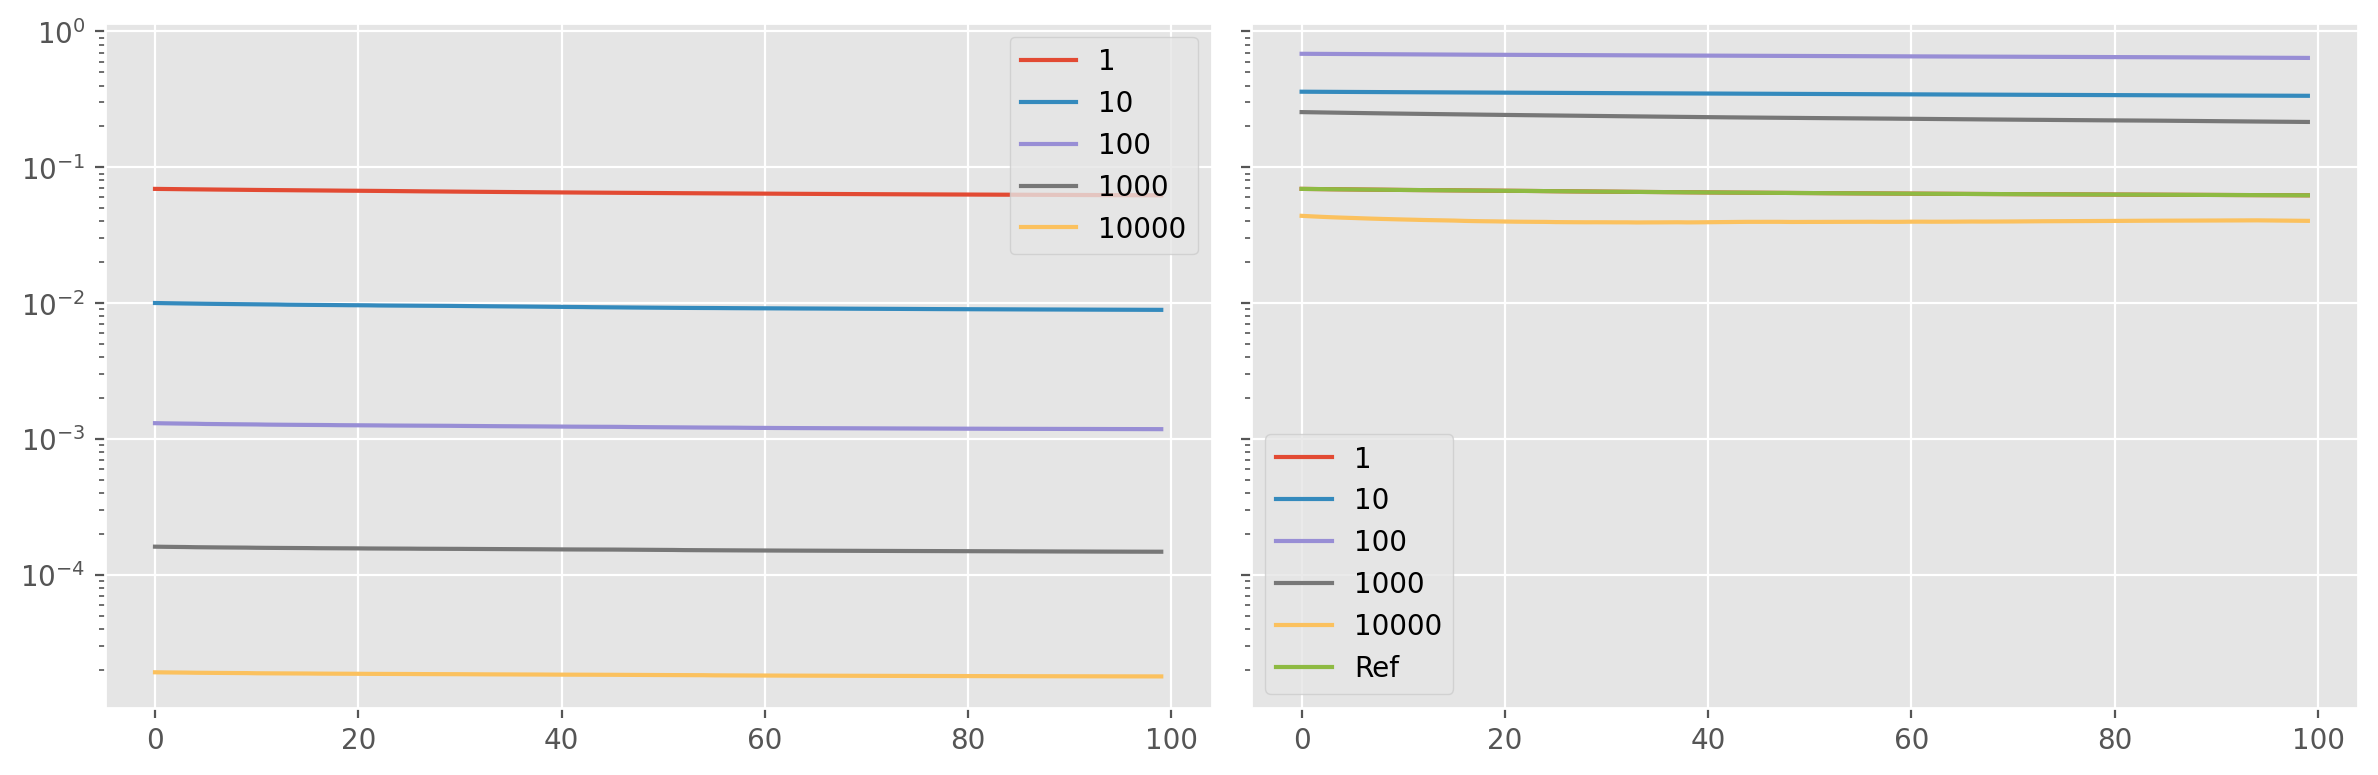

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
for w, evals in eval_negs.items():
    axes[0].plot(evals['valid_0']['binary_logloss'], label=w)
axes[0].set(yscale='log')    
axes[0].legend()    

for w, evals in eval_pos.items():
    axes[1].plot(evals['valid_0']['binary_logloss'], label=w)
axes[1].plot(evals_balanced['valid_0']['binary_logloss'], label='Ref')    
axes[1].set(yscale='log')    
axes[1].legend()    
fig.tight_layout()

1 0.8696321409087366
10 0.8457836489751384
100 0.8355252903125243
1000 0.9099738913568701
10000 0.851141766035383


1 0.8696321409087366
10 0.9044988699244019
100 0.9026673680928999
1000 0.8972605408775622
10000 0.9065349544072949


In [133]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.001,
    'n_iterations': 500,
    'verbose': -1,
    'balanced': True,
}

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
evals_balanced = {}
model = lgb.train(
    params, 
    train_data,
    valid_sets=[test_data],
    num_boost_round=num_boost_round,
    callbacks=[lgb.record_evaluation(evals_balanced)],
)

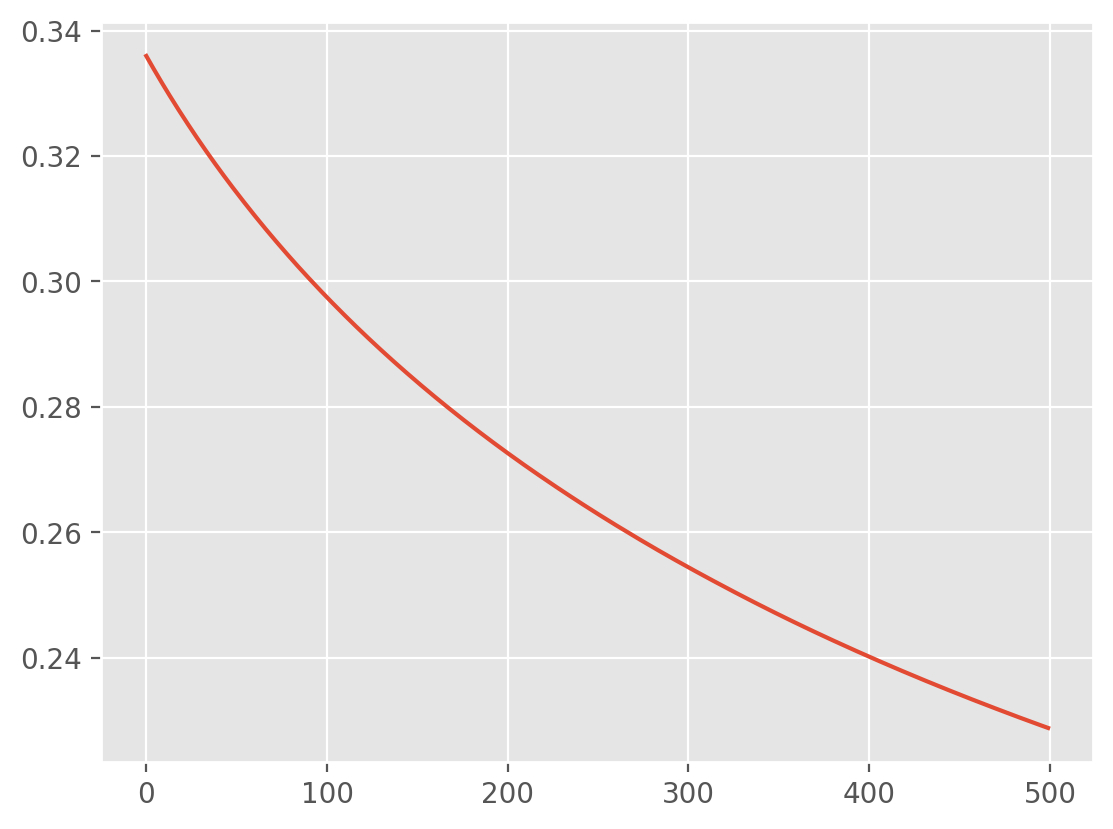

In [94]:
plt.plot(evals_balanced['valid_0']['binary_logloss'])